In [1]:
!pip install findspark
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 4.7 MB/s eta 0:00:000:00:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.4-py2.py3-none-any.whl size=317849765 sha256=9d2742e241e213e74687aec2e1106f9ea8fb2afdce2481298566a9c082ed499c
  Stored in directory: /root/.cache/pip/wheels/d9/1c/98/31e395a42d1735d18d42124971ecbbade844b50bb9845b6f4a
Successfully built pyspark


In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.storagelevel import StorageLevel

In [5]:
spark = SparkSession.builder.appName("Music") \
    .getOrCreate()
df = spark.read.csv("/kaggle/input/output/output.csv", header=True)
df = df.dropna()

AnalysisException: Path does not exist: file:/kaggle/input/output/output.csv

In [4]:
columns_to_cast = ["Acousticness", "Energy", "Liveness", "Loudness", "Tempo", "Popularity"]
for col_name in columns_to_cast:
    df = df.withColumn(col_name, col(col_name).cast("double"))

In [5]:
indexer = StringIndexer(inputCol="Explicit", outputCol="ExplicitIndex")
df = indexer.fit(df).transform(df)
assembler = VectorAssembler(
    inputCols=["Acousticness", "Energy", "Liveness", "Loudness", "Tempo", "ExplicitIndex"],
    outputCol="features",
    handleInvalid="skip"
)
df = assembler.transform(df)

In [6]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
df = scaler.fit(df).transform(df)

In [7]:
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)


In [8]:
kmeans = KMeans(featuresCol="scaledFeatures", k=3)
kmeans_model = kmeans.fit(df)
predictions = kmeans_model.transform(df)

In [20]:
silhouette_scores = []
for k in range(2, 12):
    kmeans = KMeans(featuresCol="scaledFeatures", k=k, seed=42)
    kmeans_model = kmeans.fit(df)
    
    predictions = kmeans_model.transform(df)
    
    evaluator = ClusteringEvaluator(featuresCol="scaledFeatures", metricName="silhouette", distanceMeasure="squaredEuclidean")
    silhouette_score = evaluator.evaluate(predictions)
    
    silhouette_scores.append((k, silhouette_score))
best_k, best_score = max(silhouette_scores, key=lambda x: x[1])

2
3
4
5
6
7
8
9
10
11
Silhouette Scores for different k: [(2, 0.9473948542276556), (3, -0.21975551808531962), (4, 0.2447788402899272), (5, 0.2481906620657661), (6, 0.30466687845734275), (7, -0.06121119861340394), (8, 0.1650080687577307), (9, 0.03447948000126934), (10, 0.268946216703677), (11, 0.20462123168752974)]


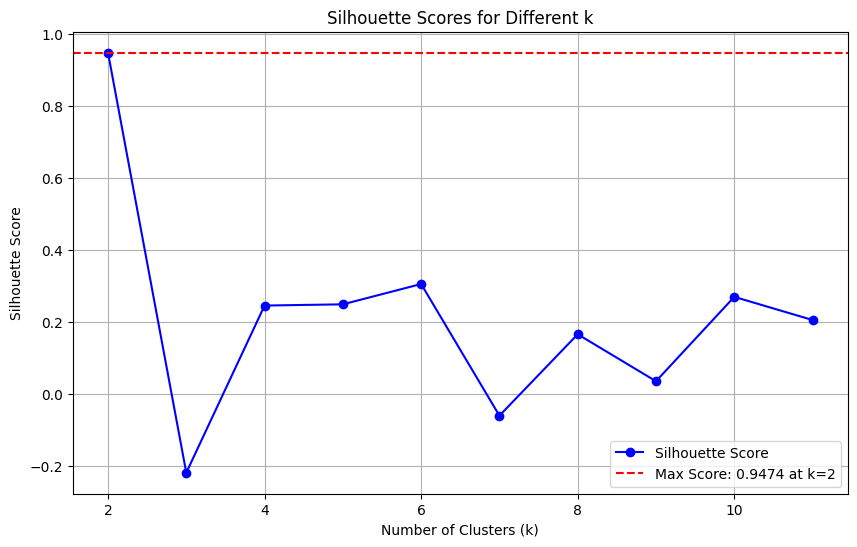

In [28]:
k_values, scores = zip(*silhouette_scores)
plt.figure(figsize=(10, 6))
plt.plot(k_values, scores, marker='o', linestyle='-', color='b', label="Silhouette Score")
plt.axhline(y=max(scores), color='r', linestyle='--', label=f"Max Score: {max(scores):.4f} at k={k_values[scores.index(max(scores))]}")
plt.title("Silhouette Scores for Different k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.legend()
plt.grid()
plt.show()

In [ ]:
kmeans = KMeans(featuresCol="scaledFeatures", k=3, seed=42)
kmeans_model = kmeans.fit(df)
predictions = kmeans_model.transform(df)

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

pandas_df = predictions.select("scaledFeatures", "prediction").toPandas()

# Giải mã `scaledFeatures` thành các giá trị riêng lẻ
scaled_features = pandas_df["scaledFeatures"].apply(lambda x: x.toArray())
scaled_features_df = pd.DataFrame(scaled_features.tolist(), columns=["Feature1", "Feature2", "Feature3", "Feature4", "Feature5", "Feature6"])

# Thêm cột dự đoán (cluster)
scaled_features_df["Cluster"] = pandas_df["prediction"]

# Plot 2D scatter plot (Feature1 và Feature2)
plt.figure(figsize=(10, 6))
for cluster in scaled_features_df["Cluster"].unique():
    cluster_data = scaled_features_df[scaled_features_df["Cluster"] == cluster]
    plt.scatter(cluster_data["Feature1"], cluster_data["Feature2"], label=f"Cluster {cluster}")

plt.title("2D Scatter Plot of Clusters")
plt.xlabel("Feature1 (Acousticness)")
plt.ylabel("Feature2 (Energy)")
plt.legend()
plt.grid()
plt.show()


NameError: name 'spark' is not defined

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

for cluster in scaled_features_df["Cluster"].unique():
    cluster_data = scaled_features_df[scaled_features_df["Cluster"] == cluster]
    ax.scatter(cluster_data["Feature1"], cluster_data["Feature2"], cluster_data["Feature3"], label=f"Cluster {cluster}")

ax.set_title("3D Scatter Plot of Clusters")
ax.set_xlabel("Feature1 (Acousticness)")
ax.set_ylabel("Feature2 (Energy)")
ax.set_zlabel("Feature3 (Liveness)")
ax.legend()

silhouette_df = pd.DataFrame(predictions.select("prediction").toPandas())
silhouette_df["silhouette_score"] = score  

plt.figure(figsize=(12, 8))
plt.barh(range(len(silhouette_df)), silhouette_df["silhouette_score"], color='blue')
plt.title("Silhouette Scores for Each Point")
plt.xlabel("Silhouette Score")
plt.ylabel("Data Points")
plt.show()